# Предсказание стоимость автомобиля на вторичном рынке.

### 1) Предобработка данных

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install category_encoders -q

In [3]:
!pip install imbalanced-learn

In [4]:
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np
from category_encoders.target_encoder import TargetEncoder 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [5]:
data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/test.csv')
data_sample_submission = pd.read_csv('./data/sample_submission.csv')
pd.set_option('display.max_columns', None)

In [6]:
print('Выведем данные по обучающим данным')
display(data_train.head(10))
data_train.info()
data_train.describe()

Выведем данные по обучающим данным


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
5,2013,Lincoln,MKZ,Base,Sedan,automatic,3ln6l2j91dr817800,mi,2.5,14894.0,black,black,"ford motor credit company,llc",22600,Thu May 21 2015 02:00:00 GMT-0700 (PDT)
6,2010,pontiac,g6,4c,NaN,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,silver,black,north state acceptance,5900,Mon Jan 12 2015 09:30:00 GMT-0800 (PST)
7,2013,Ford,Escape,SE,SUV,automatic,1fmcu0gx3duc59421,fl,4.8,26273.0,blue,gray,fields bmw,15200,Tue Feb 03 2015 01:00:00 GMT-0800 (PST)
8,2000,Hyundai,Elantra,GLS,Sedan,automatic,kmhjf35f2yu955691,oh,1.9,182624.0,black,tan,dt inventory,700,Thu Jan 22 2015 01:00:00 GMT-0800 (PST)
9,2005,Ford,Freestyle,Limited,wagon,automatic,1fmdk06135ga45438,oh,1.0,149364.0,black,tan,wells fargo dealer services,325,Tue Jun 16 2015 05:00:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


Можем заметить высокий показатель максимального пробега и слишком низкую минимальную цену

In [7]:
print('Выведем данные по тестовым данным')
display(data_test.head(10))
data_test.info()
data_test.describe()

Выведем данные по тестовым данным


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)
5,2003,Volkswagen,Passat,GLS 1.8T,wagon,automatic,wvwvd63b93e175638,nc,2.4,104155.0,silver,black,fred anderson nissan of fayetteville,Tue Jun 09 2015 03:00:00 GMT-0700 (PDT)
6,2013,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac4dh809686,il,3.7,30669.0,silver,gray,merchants leasing,Tue Mar 03 2015 02:00:00 GMT-0800 (PST)
7,2013,Ford,Explorer,Base,SUV,automatic,1fm5k7b97dgb16454,nc,3.2,87862.0,black,gray,ge fleet services for itself/servicer,Tue Feb 10 2015 01:15:00 GMT-0800 (PST)
8,2011,Infiniti,G Sedan,G37x,G Sedan,automatic,jn1cv6ar5bm411441,tn,3.5,47028.0,black,beige,nissan infiniti lt,Wed Feb 04 2015 02:30:00 GMT-0800 (PST)
9,2007,Chevrolet,Suburban,1500 LS,SUV,automatic,3gnfc16j77g158033,ga,3.4,191211.0,black,tan,riverside chevrolet inc,Tue Feb 10 2015 04:30:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


,year,condition,odometer
count,110060.000000,107681.000000,110041.000000
mean,2010.059904,3.423206,68075.693541
std,3.960432,0.951323,53523.551837
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28314.000000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98854.000000
max,2015.000000,5.000000,999999.000000


Аналогично тренировочным данным есть высокий показатель максимального пробега, значит аномалией его считать не будем

In [8]:
print('Проверка дубликатов:', data_train['vin'].str.lower().duplicated().sum())

Проверка дубликатов: 0


In [9]:
#Превратим столбец saledate в дату вместо строки
def time_for_age(data):
    data['saledate'] = pd.to_datetime(data['saledate'], utc=True)
    return data

data_train = time_for_age(data_train)
data_test = time_for_age(data_test)

In [10]:
#Побробуем логически заменить пропуски там где это возможно
def fix_nan(data,column):
    gearbox_df = data[['make', 'model', column, 'year']].\
    groupby(['make', 'model', column]).\
    agg({'year' : ['count']}).reset_index()
    # подготовим вторую вспомогательную таблицу, с моделями где используется только один тип коробки передач
    models_one_gearbox = gearbox_df.groupby(['make', 'model']).count()
    models_one_gearbox = models_one_gearbox.loc[models_one_gearbox[column] == 1]
    models_one_gearbox = models_one_gearbox.reset_index()['model']

    gearbox_df = gearbox_df[np.isin(gearbox_df, models_one_gearbox.tolist()).any(axis=1)]

    for index, row in gearbox_df.iterrows():
        data.loc[(data['model'] == \
                                row['model'].to_string().replace(" ", ""))&\
                               (data[column].isna()), column] =\
                row[column].to_string().replace(" ", "")
    
fix_nan(data_train,'transmission')
fix_nan(data_test,'transmission')
fix_nan(data_train,'body')
fix_nan(data_test,'body')

C:\Users\Артём\AppData\Local\Temp\ipykernel_14768\2962521438.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  models_one_gearbox = gearbox_df.groupby(['make', 'model']).count()
C:\Users\Артём\AppData\Local\Temp\ipykernel_14768\2962521438.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  models_one_gearbox = gearbox_df.groupby(['make', 'model']).count()
C:\Users\Артём\AppData\Local\Temp\ipykernel_14768\2962521438.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  models_one_gearbox = gearbox_df.groupby(['make', 'model']).count()
C:\Users\Артём\AppData\Local\Temp\ipykernel_14768\2962521438.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  models_one_gearbox = gearbox_df.groupby(['make', 'model']).count()


In [11]:
data_train.info()
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          432193 non-null  object             
 2   model         432113 non-null  object             
 3   trim          431899 non-null  object             
 4   body          429899 non-null  object             
 5   transmission  399828 non-null  object             
 6   vin           440236 non-null  object             
 7   state         440236 non-null  object             
 8   condition     430831 non-null  float64            
 9   odometer      440167 non-null  float64            
 10  color         439650 non-null  object             
 11  interior      439650 non-null  object             
 12  seller        440236 non-null  object             
 13  sellingprice  440236 non-null  int64        

In [12]:
#заполним пустые значения в категориальных данных на —, а в количественных на медиану
def delete_nan(data):
    data['make'] = data['make'].fillna('—')
    data['model'] = data['model'].fillna('—')
    data['trim'] = data['trim'].fillna('—')
    data['body'] = data['body'].fillna('—')
    data['transmission'] = data['transmission'].fillna('—')
    data['color'] = data['color'].fillna('—')
    data['interior'] = data['interior'].fillna('—')
    data['condition'] = data['condition'].fillna(data['condition'].median())
    data['odometer'] = data['odometer'].fillna(data['odometer'].median())
    return data
data_train = delete_nan(data_train)
data_test = delete_nan(data_test)

In [13]:
#Проверим аномальные значения и не явные дубликаты
print(sorted(data_train['make'].unique()))
def fix_make_dubl(data):
    data['make'] = data['make'].str.lower()
    data['make'] = data['make'].str.replace("vw", "volkswagen")
    data['make'] = data['make'].str.replace(" tk", "")
    data['make'] = data['make'].str.replace("-benz", "")
    data['make'] = data['make'].str.replace("-b", "")
    data['make'] = data['make'].str.replace(" truck", "")
    data['make'] = data['make'].str.replace("land rover", "landrover")
    return data
data_train = fix_make_dubl(data_train)
data_test = fix_make_dubl(data_test)
print('\nПосле обработки дубликатов\n',sorted(data_train['make'].unique()))

['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT', 'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'MINI', 'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'airstream', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'dodge tk', 'dot', 'ford', 'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai', 'jeep', 'kia', 'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b', 'mercury', 'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'smart', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'vw', '—']

После обработки дубликато

In [14]:
print(sorted(data_train['body'].unique()))
data_train['body'] = data_train['body'].str.lower()
data_test['body'] = data_test['body'].str.lower()
print('\nПосле обработки дубликатов\n',sorted(data_train['body'].unique()))

['Access Cab', 'Beetle Convertible', 'CTS Coupe', 'CTS Wagon', 'CTS-V Coupe', 'CTS-V Wagon', 'Cab Plus', 'Cab Plus 4', 'Club Cab', 'Convertible', 'Coupe', 'Crew Cab', 'CrewMax Cab', 'Double Cab', 'E-Series Van', 'Elantra Coupe', 'Extended Cab', 'G Convertible', 'G Coupe', 'G Sedan', 'G37 Convertible', 'G37 Coupe', 'Genesis Coupe', 'GranTurismo Convertible', 'Hatchback', 'King Cab', 'Koup', 'Mega Cab', 'Minivan', 'Promaster Cargo Van', 'Q60 Convertible', 'Q60 Coupe', 'Quad Cab', 'Ram Van', 'Regular Cab', 'SUV', 'Sedan', 'SuperCab', 'SuperCrew', 'TSX Sport Wagon', 'Transit Van', 'Van', 'Wagon', 'Xtracab', 'access cab', 'beetle convertible', 'cab plus 4', 'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe', 'cts-v coupe', 'double cab', 'e-series van', 'elantra coupe', 'extended cab', 'g convertible', 'g coupe', 'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe', 'granturismo convertible', 'hatchback', 'king cab', 'koup', 'mega cab', 'minivan', 'promaster car

In [15]:
print(sorted(data_train['transmission'].unique()))

['automatic', 'manual', '—']


In [16]:
print(sorted(data_train['state'].unique()))

['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la', 'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns', 'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn', 'tx', 'ut', 'va', 'wa', 'wi']


In [17]:
print(sorted(data_train['color'].unique()))

['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold', 'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple', 'red', 'silver', 'turquoise', 'white', 'yellow', '—']


In [18]:
print(sorted(data_train['interior'].unique()))

['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray', 'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan', 'white', 'yellow', '—']


Посмотрим есть ли в данных выбросы

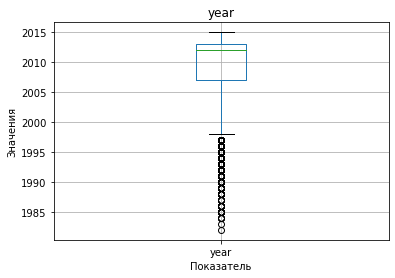

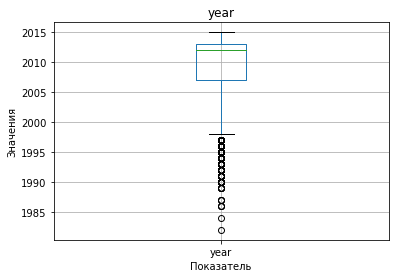

In [19]:
plt.title('year')
data_train[['year']].boxplot()
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

plt.title('year')
data_test[['year']].boxplot()
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

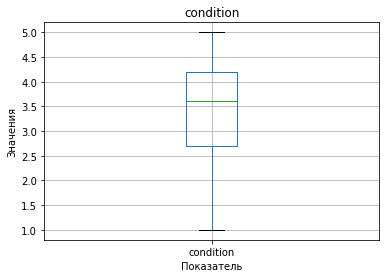

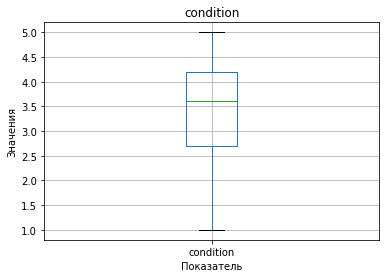

In [20]:
plt.title('condition')
data_train[['condition']].boxplot()
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

plt.title('condition')
data_test[['condition']].boxplot()
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

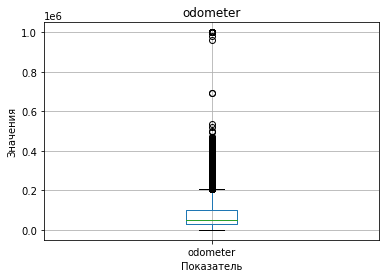

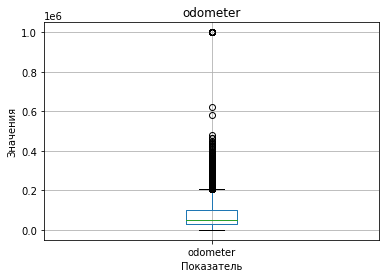

In [21]:
plt.title('odometer')
data_train[['odometer']].boxplot()
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

plt.title('odometer')
data_test[['odometer']].boxplot()
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

boxplot для пробега показывает что есть слишком большие значения, исправим некоторые из них

In [22]:
#Вместо даты выставления объявления запишим возраст автомобиля
def time_for_age(data):
    data['car_age'] = data['saledate'].dt.year - data['year']
    data = data.drop('saledate', axis=1)
    return data

data_train = time_for_age(data_train)
data_test = time_for_age(data_test)

In [23]:
data_train = data_train[~((data_train.car_age < 5) & (data_train.odometer > 800_000))]

In [24]:
print(sorted(data_train['car_age'].unique()))

print(sorted(data_test['car_age'].unique()))

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33]


Мы обнаружили странные данные -1 возраст машины, удалим эти данные в тренировочном датасете

In [25]:
data_train = data_train.loc[data_train['car_age'] != -1]

In [26]:
#Разделим данные на тренировочные и целевой признак
features_train, target_train = data_train.drop(columns = 'sellingprice', axis=1), data_train['sellingprice']

In [27]:
#удалим столбец vin
features_train = features_train.drop('vin', axis=1)
vin_test = data_test['vin']
data_test = data_test.drop('vin', axis=1)

Закодируем данные

In [28]:
columns_need = ["make", "model", "trim", "body","transmission", "state", "color", "interior", "seller"]
encoder = TargetEncoder(cols=columns_need)
encoder.fit(features_train, target_train)
features_train = encoder.transform(features_train)
display(features_train)
data_test = encoder.transform(data_test)
display(data_test)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,car_age
0,2011,14472.269471,18821.180051,14299.992376,16090.634078,13611.102383,7430.529824,4.2,111041.0,15493.494884,15675.357085,7906.528300,4
1,2014,14472.269471,12364.958980,11221.735246,11714.163464,13611.102383,14462.472499,3.5,31034.0,15493.494884,15675.357085,18164.501134,1
2,2012,11728.620093,8743.003000,8537.996097,11714.163464,13611.102383,13629.764762,2.2,35619.0,15493.494884,15675.357085,13808.496018,3
3,2003,15247.886097,18510.585577,13824.405934,16090.634078,13611.102383,13155.911469,2.8,131301.0,8298.782940,13338.355776,16458.674111,12
4,2007,14472.269471,12364.958980,14299.992376,11714.163464,13611.102383,7430.529824,2.0,127709.0,15493.494884,15675.357085,904.778831,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,11834.129589,13421.633964,16682.133090,11714.163464,13611.102383,14538.603637,4.5,20434.0,14713.160165,13338.355776,16068.338028,2
440232,2014,12347.068338,19104.089710,20649.903438,10099.804224,13611.102383,13867.100203,2.9,14675.0,14713.160165,15675.357085,14167.141009,1
440233,2008,21540.525126,33350.619048,36335.047753,15808.757691,13611.102383,14538.603637,3.7,102552.0,13927.076950,15675.357085,13999.673492,7
440234,2014,25234.263641,32544.463549,15263.508872,21549.515535,13611.102383,13155.911469,3.0,29367.0,14713.160165,10999.627620,33021.876684,1


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,car_age
0,2005,15166.812017,10821.789015,13824.405934,11714.163464,13611.102383,14538.603637,2.7,116970.0,11758.942014,15675.357085,11539.605775,10
1,2014,16869.709145,19510.273973,15471.360759,13794.867381,14212.889167,15940.278106,4.4,6286.0,14713.160165,10999.627620,19843.157583,1
2,2013,11728.620093,13043.847054,12542.081408,16090.634078,13611.102383,14403.091135,4.6,11831.0,13927.076950,15675.357085,13808.496018,2
3,2013,11841.302782,7967.194232,9822.020163,11714.163464,13611.102383,13832.315283,2.3,57105.0,11758.942014,15675.357085,9465.742025,2
4,2013,11728.620093,13229.944000,15259.274029,21549.515535,13611.102383,16966.603629,2.9,31083.0,15493.494884,15675.357085,22213.175775,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110055,2011,14904.661930,21976.870112,12423.209800,16090.634078,13611.102383,14538.603637,3.8,66085.0,12575.836096,15675.357085,10982.548261,4
110056,2014,20147.491455,19184.469443,13824.405934,11714.163464,13611.102383,13832.315283,4.8,17588.0,13927.076950,15675.357085,25782.414356,1
110057,2004,11728.620093,13072.888611,6872.857143,11714.163464,13611.102383,8606.228871,2.9,124036.0,11758.942014,10999.627620,10362.281977,11
110058,2013,11728.620093,21897.571567,13824.405934,15808.757691,11110.691036,13155.911469,2.2,27169.0,17924.269837,15675.357085,13052.515361,2


Маштабируем признаки

In [29]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_sc = scaler.transform(features_train)
features_train = pd.DataFrame(features_train_sc, columns = features_train.columns)
display(features_train)
data_test_sc = scaler.transform(data_test)
data_test = pd.DataFrame(data_test_sc, columns = data_test.columns)
display(data_test)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,car_age
0,0.241816,0.209122,0.828305,0.126694,0.788651,0.047749,-2.804699,0.820635,0.800625,0.910381,0.879659,-0.963378,-0.218713
1,0.996049,0.209122,-0.191233,-0.407007,-0.589139,0.047749,0.398062,0.075903,-0.699475,0.910381,0.879659,0.721427,-0.977531
2,0.493227,-0.433807,-0.763197,-0.872307,-0.589139,0.047749,0.018798,-1.307171,-0.613508,0.910381,0.879659,0.005982,-0.471652
3,-1.769473,0.390875,0.779257,0.044238,0.788651,0.047749,-0.197023,-0.668829,1.180492,-2.527687,-0.105337,0.441256,1.804803
4,-0.763828,0.209122,-0.191233,0.126694,-0.589139,0.047749,-2.804699,-1.519951,1.113143,0.910381,0.879659,-2.113370,0.793045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440054,0.744638,-0.409083,-0.024368,0.539704,-0.589139,0.047749,0.432737,1.139806,-0.898221,0.537489,-0.105337,0.377146,-0.724592
440055,0.996049,-0.288884,0.872981,1.227627,-1.097367,0.047749,0.126894,-0.562439,-1.006200,0.537489,0.879659,0.064887,-0.977531
440056,-0.512417,1.865452,3.122731,3.947080,0.699911,0.047749,0.432737,0.288683,0.641459,0.161851,0.879659,0.037381,0.540106
440057,0.996049,2.731019,2.995427,0.293746,2.507203,0.047749,-0.197023,-0.456048,-0.730731,0.537489,-1.091062,3.161654,-0.977531


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,car_age
0,-1.266651,0.371877,-0.434924,0.044238,-0.589139,0.047749,0.432737,-0.775219,0.911791,-0.874214,0.879659,-0.366669,1.298924
1,0.996049,0.770923,0.937124,0.329783,0.065903,1.308518,1.071142,1.033415,-1.163491,0.537489,-1.091062,0.997136,-0.977531
2,0.744638,-0.433807,-0.084026,-0.178088,0.788651,0.047749,0.371016,1.246196,-1.059524,0.161851,0.879659,0.005982,-0.724592
3,0.744638,-0.407402,-0.885710,-0.649686,-0.589139,0.047749,0.111051,-1.200780,-0.210654,-0.874214,0.879659,-0.707287,-0.724592
4,0.744638,-0.433807,-0.054639,0.293012,2.507203,0.047749,1.538591,-0.562439,-0.698557,0.910381,0.879659,1.386396,-0.724592
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110055,0.241816,0.310446,1.326638,-0.198698,0.788651,0.047749,0.432737,0.395074,-0.042283,-0.483853,0.879659,-0.458162,-0.218713
110056,0.996049,1.539017,0.885674,0.044238,-0.589139,0.047749,0.111051,1.458976,-0.951583,0.161851,0.879659,1.972620,-0.977531
110057,-1.518062,-0.433807,-0.079440,-1.161005,-0.589139,0.047749,-2.269217,-0.562439,1.044276,-0.874214,-1.091062,-0.560036,1.551864
110058,0.744638,-0.433807,1.314116,0.044238,0.699911,-5.190718,-0.197023,-1.307171,-0.771943,2.071952,0.879659,-0.118183,-0.724592


Определение кореляции

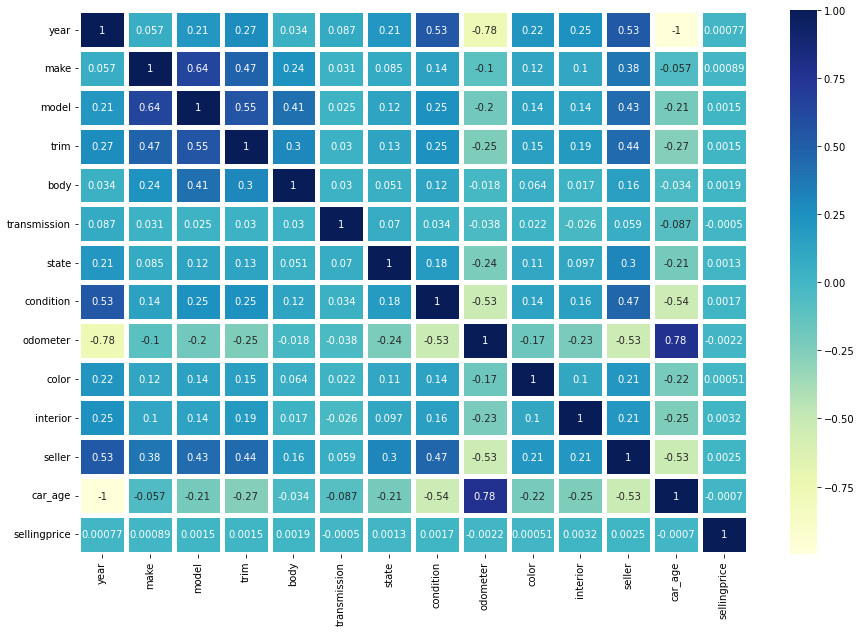

In [30]:
data_corr = features_train.copy()
data_corr['sellingprice'] = target_train

plt.figure(figsize=(15, 10))
data_train_plot = sns.heatmap(data_corr.corr(), cmap="YlGnBu", annot=True, linewidths = 5)    
plt.show()

#### Итоги по обработке данных
- Пропуски в данных были заменены где это возможно сделать логически, а где не возможно заменены на —
- Устранены дубликаты
- Устранены некоторые аномалии, когда год объявления раньше года машины и машины с аномально большим пробегом
- Слишком больших и малых значений, не поддающихся логике, нет
- Избавились от не нужных в исследовании столбцов
- Были закодированы категориальные данные методом OrdinalEncoder
- Проведено масштабирование признаков
- Разбили данные на тренировочные и целевой признак
- Построена матрица корреляций для определения значимости признаков.

# Обучение модеелей

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

#Исследование модели решающего дерева
params = {
    'max_depth': [8, 10, 12, 14, 16, 18],
    'min_samples_leaf': [5, 10, 15, 20]
}

imba_pipeline = make_pipeline(RandomOverSampler(random_state=12345), 
                              DecisionTreeRegressor(random_state=12345))

new_params = {'decisiontreeregressor__' + key: params[key] for key in params}
best_model_DTR = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='neg_mean_absolute_percentage_error',
                        return_train_score=True,  n_jobs=-1)

best_model_DTR.fit(features_train, target_train)

print(best_model_DTR.best_params_)
print(best_model_DTR.best_score_)

{'decisiontreeregressor__max_depth': 18, 'decisiontreeregressor__min_samples_leaf': 15}
-0.24482501507918775


In [32]:
#Исследование модели случайного леса
params = {
    'max_depth': [10, 15],
    'n_estimators': [50, 100]
}

imba_pipeline = make_pipeline(RandomOverSampler(random_state=12345), 
                              RandomForestRegressor(random_state=12345))

new_params = {'randomforestregressor__' + key: params[key] for key in params}
best_model_RFR = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='neg_mean_absolute_percentage_error',
                        return_train_score=True,  n_jobs=-1)

best_model_RFR.fit(features_train, target_train)

print(best_model_RFR.best_params_)
print(best_model_RFR.best_score_)

{'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 50}
-0.25676293649839305


In [36]:
#Исследование модели catBoost
params = [{
    'n_estimators': [100, 250, 500],
    'depth': [4, 10,15]
}]

model = GridSearchCV(estimator = CatBoostRegressor(loss_function = 'MAPE',  verbose = 250), param_grid = params,)
model.fit(features_train, target_train)

0:	learn: 0.8349220	total: 20ms	remaining: 1.98s
99:	learn: 0.6942381	total: 1.65s	remaining: 0us
0:	learn: 0.8343205	total: 19ms	remaining: 1.88s
99:	learn: 0.8205178	total: 1.76s	remaining: 0us
0:	learn: 0.8420782	total: 18ms	remaining: 1.78s
99:	learn: 0.6704722	total: 1.62s	remaining: 0us
0:	learn: 0.8405354	total: 17.9ms	remaining: 1.77s
99:	learn: 0.6573830	total: 1.66s	remaining: 0us
0:	learn: 0.8311326	total: 18.1ms	remaining: 1.79s
99:	learn: 0.7084710	total: 1.61s	remaining: 0us
0:	learn: 0.8349220	total: 19.3ms	remaining: 4.8s
249:	learn: 0.6404756	total: 4.09s	remaining: 0us
0:	learn: 0.8343205	total: 18.8ms	remaining: 4.68s
249:	learn: 0.7711712	total: 4.4s	remaining: 0us
0:	learn: 0.8420782	total: 17.7ms	remaining: 4.41s
249:	learn: 0.6474765	total: 4.12s	remaining: 0us
0:	learn: 0.8405354	total: 22.3ms	remaining: 5.56s
249:	learn: 0.6466575	total: 4.05s	remaining: 0us
0:	learn: 0.8311326	total: 18.3ms	remaining: 4.56s
249:	learn: 0.6810017	total: 4.03s	remaining: 0us
0:	

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000001D51E0C4F40>,
             param_grid=[{'depth': [4, 10, 15],
                          'n_estimators': [100, 250, 500]}])

In [37]:
model.best_params_

{'depth': 15, 'n_estimators': 500}

In [38]:
catboost_model_best = CatBoostRegressor(
            loss_function='MAPE',
            n_estimators=1000,
            depth=15,
            verbose=250
)
catboost_model_best.fit(features_train, target_train)

0:	learn: 0.8293903	total: 203ms	remaining: 3m 23s
250:	learn: 0.4591799	total: 1m 15s	remaining: 3m 45s
500:	learn: 0.4396472	total: 2m 33s	remaining: 2m 32s
750:	learn: 0.4328819	total: 4m 9s	remaining: 1m 22s
999:	learn: 0.4272400	total: 5m 47s	remaining: 0us


Лучшие показатели у модели решающего дерева, поэтому сделаем на ней предсказание и сохраним результат

In [39]:
best_model_predict = best_model_DTR.predict(data_test)
dataset = pd.DataFrame({'vin': vin_test, 'sellingprice': best_model_predict}, columns=['vin', 'sellingprice'])

In [40]:
dataset.to_csv('predict.csv', index=False)